# Simple Serie Test
Training vanilla transformer(encoder-decoder) to forecast a simple generated serie
> This can be view as a "sanity check" of the implementation correcteness

---
### Imports

In [3]:
# !pip3 install yfinance

In [4]:
# python
import numpy as np
import math
import matplotlib.pyplot as plt
import yfinance as yf 
# deep learning
import torch
from torch import nn
# local 
from utils import (
    print_losses,
    create_chunks, make_batches, generate_data,
    generate_serie_2, 
    plot_predictions,
    generate_square_subsequent_mask,
)
from models.transformer import TimeSeriesTransformer
!export CUDA_VISIBLE_DEVICES=0

In [2]:
from layers import Time2Vec

dec_x = torch.tensor(np.random.randn(32,7,1), dtype=torch.float32)
print(dec_x.shape)
l1 = nn.Linear(in_features=1, out_features=512)
l = Time2Vec(input_dim=1, embed_dim=512)

l(dec_x).shape



torch.Size([32, 7, 1])


torch.Size([32, 7, 512])

In [5]:
import numpy as np
import torch
from torch import nn
from utils.plot import generate_square_subsequent_mask
#
from layers import Time2Vec, PositionalEncoding

class TimeSeriesTransformer(nn.Module):
    def __init__(self, model_params: dict):
        super(TimeSeriesTransformer, self).__init__()
        # Set model vars
        expected_vars = ['in_features','d_model','input_len',
                         'encoder_nheads','encoder_nlayers','encoder_dropout',
                         'decoder_nheads','decoder_nlayers','decoder_dropout',
                         'feedforward_dim','forecast_horizon','seed']
        for v in expected_vars:
            assert v in model_params.keys(), f'Key "{v}" is missing on params dict'
            vars(self)[v] = model_params[v]
        #
        # Pre-configuration (to produce same result in inference/predict)
        #
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.seed)
        
        #
        # Encoder layers
        #
        self.encoder_input_layer = nn.Linear(in_features=self.in_features, out_features=self.d_model)
        self.time2vec = Time2Vec(input_dim=self.in_features, embed_dim=self.d_model) #PositionalEncoding(self.d_model)
        encoder_layer = nn.TransformerEncoderLayer(
                            d_model=self.d_model,
                            nhead=self.encoder_nheads,
                            dim_feedforward=self.feedforward_dim,
                            dropout=self.encoder_dropout,
                            batch_first=True)
        self.encoder_block = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=self.encoder_nlayers, norm=None)
        #
        # Decoder layers
        #
        self.decoder_input_layer = nn.Linear(in_features=self.in_features, out_features=self.d_model)
        decoder_layer = nn.TransformerDecoderLayer(
                            d_model=self.d_model, 
                            nhead=self.decoder_nheads,
                            dim_feedforward=self.feedforward_dim,
                            dropout=self.decoder_dropout,
                            batch_first=True
                            )
        self.decoder_block = nn.TransformerDecoder(decoder_layer=decoder_layer,num_layers=self.decoder_nlayers, norm=None)
        self.decoder_dense_mapping = nn.Linear(self.d_model, self.in_features)
        # self.init_weights()
    
    def get_train_masks(self,):
        # which will mask the encoder output
        memory_mask = generate_square_subsequent_mask(self.forecast_horizon, self.input_len)
        # which will mask the decoder input
        tgt_mask = generate_square_subsequent_mask(self.forecast_horizon, self.forecast_horizon)
        return memory_mask, tgt_mask

    def init_weights(self):
        initrange = 0.1    
        # self.decoder_dense_mapping.bias.data.zero_()
        self.decoder_dense_mapping.weight.data.uniform_(-initrange, initrange)

    def encode(self, x, verbose):
        if verbose: print(f'#1) Encoder input shape = {x.shape}')
        
        y1 = self.encoder_input_layer(x)    # linear transformation (embedding)     
        y2 = self.time2vec(x) # positional encoding 
        y = y2 + y1
        if verbose: print(f'#3) Embedding + Time2vec output: {y.shape}')

        # encoder block 
        y = self.encoder_block(y)
        if verbose: print(f'#4) Encoder block output: {y.shape}\n')
        return y
    
    def decode(self, x, enc_y,  memory_mask, tgt_mask, verbose):
        if verbose: print(f'#5) Decoder input shape = {x.shape}')
        y1 = self.decoder_input_layer(x)    # linear transformation (embedding)     
        y2 = self.time2vec(x) # positional encoding 
        y = y2 + y1
        if verbose: print(f'#6) Decoder embedding + Time2vec output: {y.shape}')

        
        # Pass decoder input through decoder input layer
        y = self.decoder_block(
            tgt=y,
            memory=enc_y,
            tgt_mask=tgt_mask,
            memory_mask=memory_mask
        )
        if verbose: print(f'#8) Decoder block output: {y.shape}')

        # mapping (dense)
        y = self.decoder_dense_mapping(y)
        if verbose: print(f'#9) Decoder mapping(dense) output: {y.shape}')

        return y

    def forward(self, enc_x, dec_x, memory_mask=None, tgt_mask=None, verbose=False):
        enc_y = self.encode(enc_x, verbose)
        dec_y = self.decode(dec_x, enc_y, memory_mask, tgt_mask, verbose)
        return dec_y
    
INPUT_LEN = 17
FORECAST_HORIZON = 8
model_params = {
    'in_features':1, # The number of input variables. 1 if univariate forecasting.
    'input_len':INPUT_LEN,
    'max_input_len':50, # What's the longest sequence the model will encounter? Used to make the positional encoder
    'forecast_horizon':FORECAST_HORIZON, # Length of the target sequence, i.e. how many time steps should your forecast cover
    'd_model':16, # model embedding dimension This can be any value divisible by n_heads. 512 is used in the original transformer paper.
    'encoder_nheads':8, # The number of attention heads (parallel attention layers)
    'encoder_nlayers':2, # Number of times the layer is stacked
    'encoder_dropout': 0,#0.1,
    'encoder_ps_dropout': 0,#0.1,
    'feedforward_dim':128,
    'decoder_nheads':8, # The number of attention heads (parallel attention layers)
    'decoder_nlayers':2, # Number of times the layer is stacked
    'decoder_dropout': 0,#0.1, # with zeroed dropout we can reproduce the outputs.
    'seed':7,
}
enc_x, dec_x, tgt_y = make_batches(generate_data(1000, plot=False), INPUT_LEN, FORECAST_HORIZON)

model = TimeSeriesTransformer(model_params)
model(enc_x[:2], dec_x[:2]).shape

torch.Size([2, 8, 1])

In [6]:
# sudo rmmod nvidia_uvm && modprobe nvidia_uvm
# sudo modprobe nvidia_uvm

---
### Global Variables

In [163]:
# Past steps used to forecast
INPUT_LEN = 128
# Future steps to forecast during training
FORECAST_HORIZON = 15

---
### Data Generation

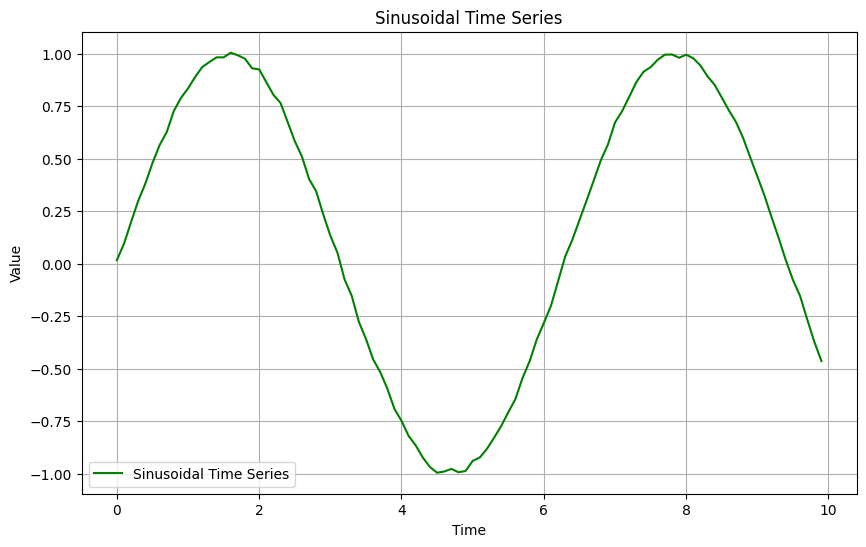

tensor([0.0169, 0.0952, 0.1990, 0.2997, 0.3816, 0.4795, 0.5647, 0.6268, 0.7276,
        0.7894])
5000
num of batches = 4858
[0.51029156 0.54849516 0.59916875 0.64826768 0.688258   0.73604679
 0.77762233 0.80789924 0.85712049 0.8872777 ]


In [164]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# original_data = pd.read_csv('./Sunspots.csv')['Monthly Mean Total Sunspot Number'].values
original_data = generate_data(5_000)# generate_serie_simple(500, True, True)
print(original_data[:10])
scaler = MinMaxScaler()
data = scaler.fit_transform(original_data.reshape(-1,1)).flatten()
print(len(data))
enc_x, dec_x, tgt_y = make_batches(data, INPUT_LEN, FORECAST_HORIZON)
print(f'num of batches = {enc_x.shape[0]}')
print(data[:10])

Transformer input style

In [161]:
# data = generate_serie_2(200, False, True)
# enc_x, dec_x, tgt_y = make_batches(data, INPUT_LEN, FORECAST_HORIZON)
# print(f'num of batches = {enc_x.shape[0]}')


---
### TimeSeriesTransformer

Model Config

In [162]:

model_params = {
    'in_features':1, # The number of input variables. 1 if univariate forecasting.
    'input_len':INPUT_LEN,
    'max_input_len':50, # What's the longest sequence the model will encounter? Used to make the positional encoder
    'forecast_horizon':FORECAST_HORIZON, # Length of the target sequence, i.e. how many time steps should your forecast cover
    'd_model':16, # model embedding dimension This can be any value divisible by n_heads. 512 is used in the original transformer paper.
    'encoder_nheads':2, # The number of attention heads (parallel attention layers)
    'encoder_nlayers':2, # Number of times the layer is stacked
    'encoder_dropout': 0.1,
    'encoder_ps_dropout': 0.1,
    'feedforward_dim':8,
    'decoder_nheads':1, # The number of attention heads (parallel attention layers)
    'decoder_nlayers':1, # Number of times the layer is stacked
    'decoder_dropout': 0.1, # with zeroed dropout we can reproduce the outputs.
    'seed':7,
}

model = TimeSeriesTransformer(model_params)
model(enc_x[:2], dec_x[:2]).shape
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Num of weights:',pytorch_total_params)

Num of weights: 5529


---
### Train Loop

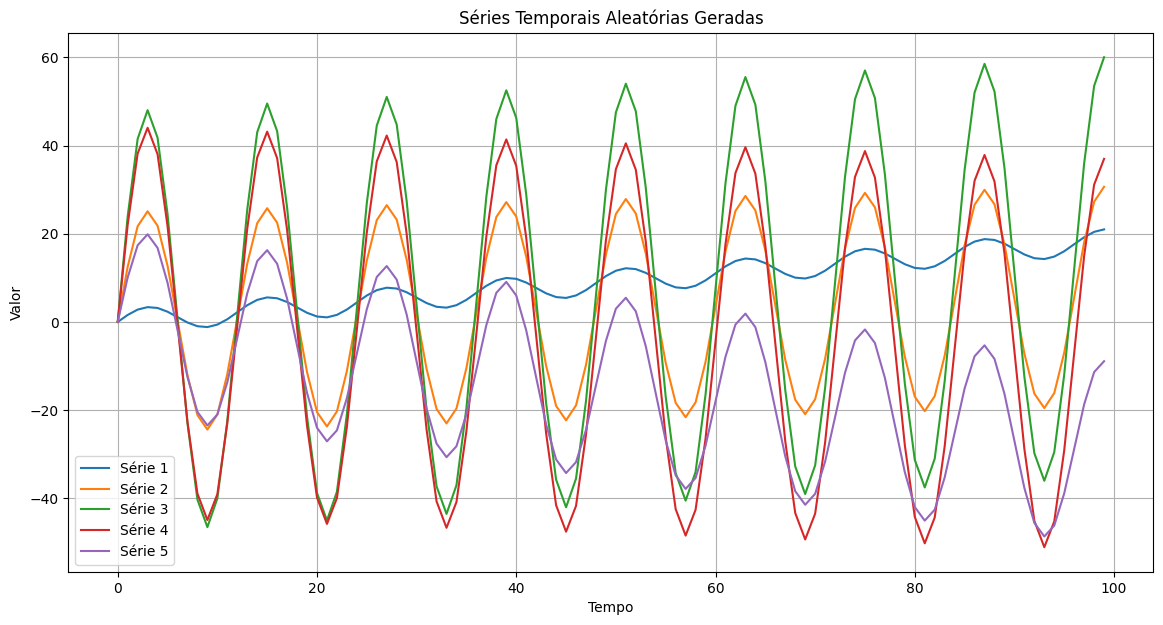

In [212]:
import numpy as np
import matplotlib.pyplot as plt

# Função para gerar uma série temporal aleatória com tendência, ruído e sazonalidade
def generate_time_series(length=100, trend_strength=0.0, seasonal_strength=0.0, noise_strength=1.0):
    time = np.arange(length)
    trend = trend_strength * time / length
    seasonal = seasonal_strength * np.sin(2 * np.pi * time / 12)
    noise = noise_strength * np.random.randn(length)
    series = trend + seasonal + noise
    return series

# Número de séries temporais a serem geradas
num_series = 10

# Listas para armazenar as séries temporais geradas
time_series = []

# Gerar as séries temporais
for _ in range(num_series):
    trend_strength = np.random.uniform(-50, 30)  # Valores aleatórios para a força da tendência
    seasonal_strength = np.random.uniform(-10, 50.0)  # Valores aleatórios para a força da sazonalidade
    noise_strength = np.random.uniform(-10, 20)  # Valores aleatórios para a força do ruído

    series = generate_time_series(length=100, trend_strength=trend_strength, seasonal_strength=seasonal_strength, noise_strength=0)
    time_series.append(series)

# Exibir algumas séries temporais geradas
plt.figure(figsize=(14, 7))
for i in range(5):
    plt.plot(time_series[i], label=f"Série {i+1}")

plt.title('Séries Temporais Aleatórias Geradas')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1 loss: 0.11004401743412018 | lr = 0.00505
Epoch 2 loss: 0.02224922925233841 | lr = 0.0051005
Epoch 3 loss: 0.014306733384728432 | lr = 0.005151505
Epoch 4 loss: 0.010724221356213093 | lr = 0.00520302005
Epoch 5 loss: 0.008813648484647274 | lr = 0.0052550502505
Epoch 6 loss: 0.007230793591588736 | lr = 0.005307600753005
Epoch 7 loss: 0.006718446966260672 | lr = 0.005360676760535051
Epoch 8 loss: 0.0060517443343997 | lr = 0.005414283528140401
Epoch 9 loss: 0.00560963898897171 | lr = 0.005468426363421805
Epoch 10 loss: 0.00517244404181838 | lr = 0.005523110627056023
Epoch 11 loss: 0.004706984385848045 | lr = 0.005578341733326583
Epoch 12 loss: 0.004448037128895521 | lr = 0.005634125150659849
Epoch 13 loss: 0.004022031091153622 | lr = 0.005690466402166448
Epoch 14 loss: 0.0037650619633495808 | lr = 0.0057473710661881125
Epoch 15 loss: 0.0035677957348525524 | lr = 0.005804844776849994
Epoch 16 loss: 0.00330442120321095 | lr = 0.005862893224618494
Epoch 17 loss: 0.003043705364689231 |

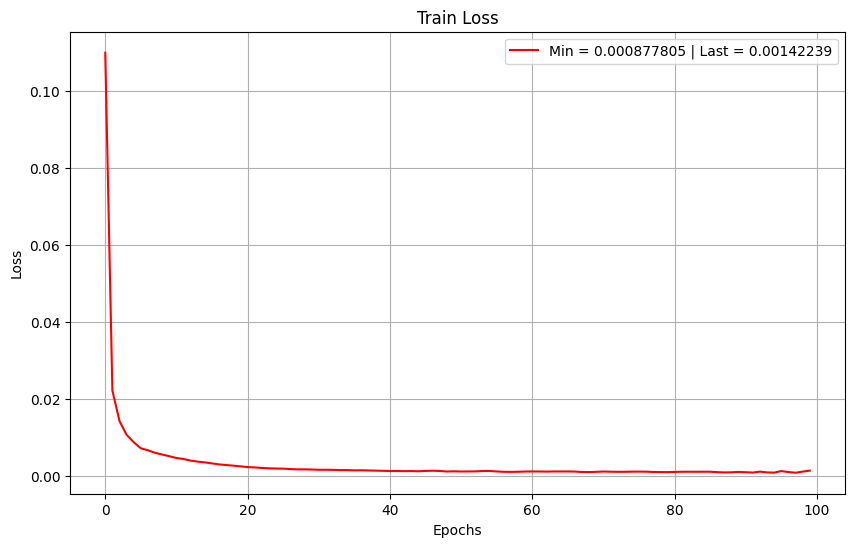

Epoch 1 loss: 0.011113502085208893 | lr = 0.00475
Epoch 2 loss: 0.002923713531345129 | lr = 0.0045125
Epoch 3 loss: 0.0019158633658662438 | lr = 0.004286875
Epoch 4 loss: 0.0014674430713057518 | lr = 0.00407253125
Epoch 5 loss: 0.0012915574479848146 | lr = 0.0038689046874999995
Epoch 6 loss: 0.0011792744044214487 | lr = 0.003675459453124999
Epoch 7 loss: 0.0011128063779324293 | lr = 0.003491686480468749
Epoch 8 loss: 0.0010721769649535418 | lr = 0.0033171021564453113
Epoch 9 loss: 0.0010493898298591375 | lr = 0.0031512470486230455
Epoch 10 loss: 0.001028854283504188 | lr = 0.002993684696191893
Epoch 11 loss: 0.0010161360260099173 | lr = 0.0028440004613822984
Epoch 12 loss: 0.0009980915347114205 | lr = 0.0027018004383131834
Epoch 13 loss: 0.000987765728496015 | lr = 0.002566710416397524
Epoch 14 loss: 0.000976922339759767 | lr = 0.0024383748955776477
Epoch 15 loss: 0.0009716307977214456 | lr = 0.002316456150798765
Epoch 16 loss: 0.0009570435504429042 | lr = 0.0022006333432588268
Epoch 1

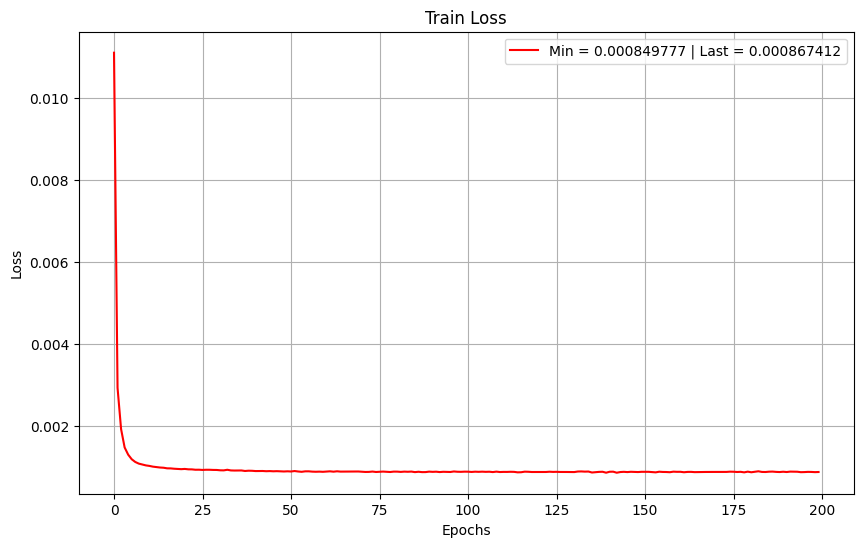

In [147]:

def train(model, enc_x, dec_x, tgt_y, epochs=100, lr=0.005, gamma=0.95):
    memory_mask, tgt_mask = model.get_train_masks()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=gamma)
    criterion = nn.MSELoss()
    #
    memory_mask, tgt_mask, model = memory_mask.to('cuda'), tgt_mask.to('cuda'), model.to('cuda') 
    enc_x, dec_x,  tgt_y  = enc_x.to('cuda'), dec_x.to('cuda'), tgt_y.to('cuda')
    #
    data_len = enc_x.shape[0]
    batch_size = 512
    losses = []
    for epoch_i in range(epochs): 
        epoch_losses = []
        for i in range(0, data_len, batch_size):
            batch_enc_x, batch_enc_y, batch_tgt_y = enc_x[i:i+batch_size], dec_x[i:i+batch_size],  tgt_y[i:i+batch_size]
            # zero the parameter gradients
            optimizer.zero_grad()
            pred_y = model(batch_enc_x, batch_enc_y, None, tgt_mask)
            
            # Compute and backprop loss
            loss = criterion(batch_tgt_y, pred_y)
            loss.backward()
            epoch_losses.append(loss.detach().cpu())
            optimizer.step() #  Take optimizer step
        scheduler.step()
        
        losses.append(np.mean(epoch_losses))
        print(f'Epoch {epoch_i+1} loss: {np.mean(epoch_losses)} | lr =',optimizer.param_groups[0]['lr'])
    print_losses(losses, offset=0)

model = TimeSeriesTransformer(model_params)
train(model, enc_x, dec_x, tgt_y, 100, lr=0.005, gamma=1.01)
train(model, enc_x, dec_x, tgt_y, 200, lr=0.005, gamma=0.95)

In [148]:
memory_mask, tgt_mask, model = memory_mask.cpu(), tgt_mask.cpu(), model.cpu()
enc_x, dec_x,  tgt_y  = enc_x.cpu(), dec_x.cpu(), tgt_y.cpu()


---
### Inference Loop

Single Batch

torch.Size([1, 101, 1])


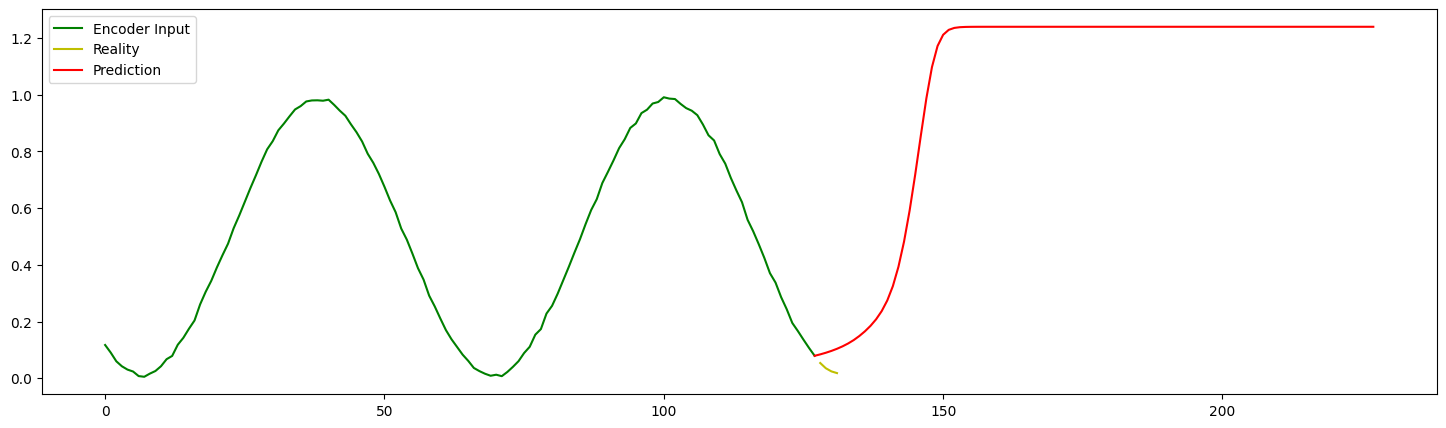

array([0.07910296, 0.08412008, 0.08982138, 0.09633802, 0.10383372,
       0.11251719, 0.12266009, 0.13462742, 0.1489286 , 0.165464  ,
       0.18474485, 0.2078752 , 0.2366971 , 0.27421832, 0.32482457,
       0.39314198, 0.48188323, 0.5913479 , 0.71843827, 0.8550439 ,
       0.987398  , 1.0976325 , 1.1719903 , 1.2116038 , 1.2290193 ,
       1.2358572 , 1.2384058 , 1.2393361 , 1.239673  , 1.2397946 ,
       1.2398386 , 1.2398542 , 1.2398602 , 1.2398622 , 1.239863  ,
       1.2398634 , 1.2398636 , 1.2398635 , 1.2398634 , 1.2398636 ,
       1.2398635 , 1.2398634 , 1.2398636 , 1.2398635 , 1.2398634 ,
       1.2398636 , 1.2398635 , 1.2398634 , 1.2398636 , 1.2398635 ,
       1.2398634 , 1.2398636 , 1.2398635 , 1.2398634 , 1.2398636 ,
       1.2398635 , 1.2398634 , 1.2398636 , 1.2398635 , 1.2398634 ,
       1.2398636 , 1.2398635 , 1.2398634 , 1.2398634 , 1.2398634 ,
       1.2398636 , 1.2398635 , 1.2398634 , 1.2398636 , 1.2398635 ,
       1.2398634 , 1.2398636 , 1.2398635 , 1.2398634 , 1.23986

In [149]:
def infer_single_batch(model, src, tgt_y, forecast_horizon=-1):
    forecast_horizon = max(forecast_horizon, tgt_y.shape[1])
    input_steps = src.shape[1]
    tgt_steps = tgt_y.shape[1]
    with torch.no_grad():
        output = torch.zeros(1, forecast_horizon + 1, 1)
        output[0, 0, 0] = src[0, -1]
        for i in range(forecast_horizon):
            dim_a = output.shape[1]
            tgt_mask = generate_square_subsequent_mask(dim_a, dim_a)
            y = model(src, output, None, tgt_mask)[0,i,0]
            output[0,i+1,0] = y

        print(output.shape)
    #
    # output = output[0,1:,0] # remove the SOS token
    output = output.detach().numpy().flatten()
    time = np.arange(0, input_steps + forecast_horizon)
    plt.figure(figsize=(18,5))
    plt.plot(time[:input_steps], src.numpy().flatten(), 'g', label='Encoder Input')
    plt.plot(time[input_steps:input_steps+tgt_steps], tgt_y.numpy().flatten(), 'y', label='Reality')
    plt.plot(time[input_steps-1:], output, 'r', label='Prediction') # o 1 valor de output é o ultimo tipestamp do input
    plt.legend()
    plt.show()
    return output

model.eval() # sets all layers to eval
batch_index = 920
infer_single_batch(model, 
                   enc_x[batch_index:batch_index+1], 
                   tgt_y[batch_index:batch_index+1],
                   forecast_horizon=100)

